# Z-Score Indicator Visualization

This notebook demonstrates the Z-Score indicator, which measures how many standard deviations a value is away from its rolling mean.

**Use Cases:**
- Detect overbought/oversold conditions
- Identify price anomalies
- Mean reversion trading signals
- Volume spikes detection

In [1]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from indikator.zscore import zscore

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

2025-11-27 15:17:13.681 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'threshold' has constraints: {'ge': 0.0, 'le': 1.0}
2025-11-27 15:17:13.682 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'min_distance_pct' has constraints: {'ge': 0.0, 'le': 1.0}
2025-11-27 15:17:13.682 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'confirmation_bars' has constraints: {'ge': 0}
2025-11-27 15:17:13.686 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'epsilon' has constraints: {'gt': 0.0}
2025-11-27 15:17:13.686 | DEBUG    | hipr.config:configurable:705 - Creating Config for 'zigzag_legs' with 4 hyperparameter(s): ['threshold', 'min_distance_pct', 'confirmation_bars', 'epsilon']
2025-11-27 15:17:13.696 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'window' has constraints: {'ge': 2}
2025-11-27 15:17:13.696 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'epsilon' has constraints: 

## Scenario 1: Price Spike Detection
Demonstrate how Z-Score identifies sudden price movements

/tmp/user/ipykernel_2525924/3655555598.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


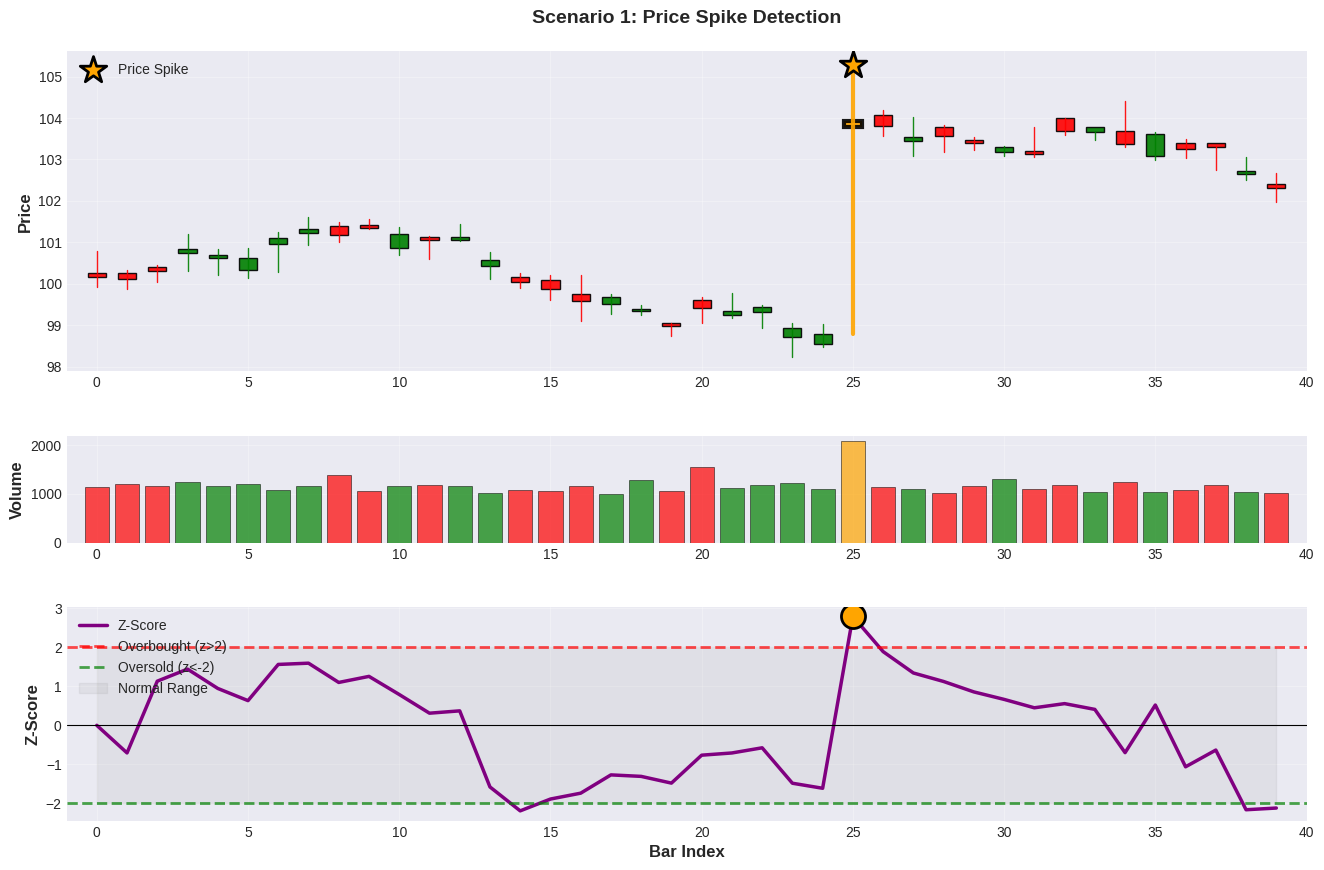

Max Z-Score at spike: 2.79
This is 2.8 standard deviations above normal!

Price at bar 24: $98.77
Price at bar 25: $103.77 (+$5.00)


In [2]:
# Create data with normal trading and a price spike
n = 40
dates = pd.date_range('2024-01-01 09:30', periods=n, freq='5min')

# Build 40 closes with spike at position 25
closes_part1 = 100 + np.cumsum(np.random.randn(25) * 0.3)
spike_close = closes_part1[-1] + 5  # Spike
closes_part2 = spike_close + np.cumsum(np.random.randn(14) * 0.3)
all_closes = np.concatenate([closes_part1, [spike_close], closes_part2])

# Create OHLC from closes
opens = all_closes + np.random.randn(n) * 0.2
highs = np.maximum(opens, all_closes) + np.abs(np.random.randn(n)) * 0.3
lows = np.minimum(opens, all_closes) - np.abs(np.random.randn(n)) * 0.3

# Make spike more dramatic
highs[25] = all_closes[25] + 1.5
lows[25] = all_closes[24]

volumes = 1000 + np.abs(np.random.randn(n)) * 200
volumes[25] *= 2  # Higher volume on spike

df1 = pd.DataFrame({'open': opens, 'high': highs, 'low': lows, 'close': all_closes, 'volume': volumes}, index=dates)

result1 = zscore(df1, column='close', window=10)

# Plot
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 1, height_ratios=[3, 1, 2], hspace=0.3)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Candlestick chart
for i in range(len(df1)):
    color = 'green' if df1['close'].iloc[i] >= df1['open'].iloc[i] else 'red'
    if i == 25:  # Spike bar
        color = 'orange'
        lw = 3
    else:
        lw = 1
    # High-low line
    ax1.plot([i, i], [df1['low'].iloc[i], df1['high'].iloc[i]], color=color, linewidth=lw, alpha=0.9)
    # Body
    height = abs(df1['close'].iloc[i] - df1['open'].iloc[i])
    if height < 0.05: height = 0.1
    bottom = min(df1['open'].iloc[i], df1['close'].iloc[i])
    ax1.add_patch(plt.Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, edgecolor='black', linewidth=lw, alpha=0.9))

# Highlight spike
ax1.scatter([25], [df1['high'].iloc[25]], s=400, marker='*', color='orange', edgecolor='black', linewidth=2, zorder=5, label='Price Spike')
ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('Scenario 1: Price Spike Detection', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.set_xlim(-1, len(df1))

# Volume
colors_vol = ['orange' if i == 25 else 'green' if df1['close'].iloc[i] >= df1['open'].iloc[i] else 'red' for i in range(len(df1))]
ax2.bar(range(len(df1)), df1['volume'], color=colors_vol, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_ylabel('Volume', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-1, len(df1))

# Z-Score plot
zscore_vals = result1['close_zscore'].values
ax3.plot(range(len(zscore_vals)), zscore_vals, 'purple', linewidth=2.5, label='Z-Score')
ax3.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax3.axhline(2, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Overbought (z>2)')
ax3.axhline(-2, color='green', linestyle='--', alpha=0.7, linewidth=2, label='Oversold (z<-2)')
ax3.fill_between(range(len(df1)), -2, 2, alpha=0.1, color='gray', label='Normal Range')
ax3.scatter([25], [zscore_vals[25]], s=300, marker='o', color='orange', edgecolor='black', linewidth=2, zorder=5)
ax3.set_xlabel('Bar Index', fontsize=12, fontweight='bold')
ax3.set_ylabel('Z-Score', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='upper left')
ax3.set_xlim(-1, len(df1))

plt.tight_layout()
plt.show()

print(f"Max Z-Score at spike: {result1['close_zscore'].iloc[25]:.2f}")
print(f"This is {result1['close_zscore'].iloc[25]:.1f} standard deviations above normal!")
print(f"\nPrice at bar 24: ${df1['close'].iloc[24]:.2f}")
print(f"Price at bar 25: ${df1['close'].iloc[25]:.2f} (+${df1['close'].iloc[25] - df1['close'].iloc[24]:.2f})")

## Scenario 2: Window Parameter Effect
Compare different window sizes

/tmp/user/ipykernel_2525924/1379833276.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


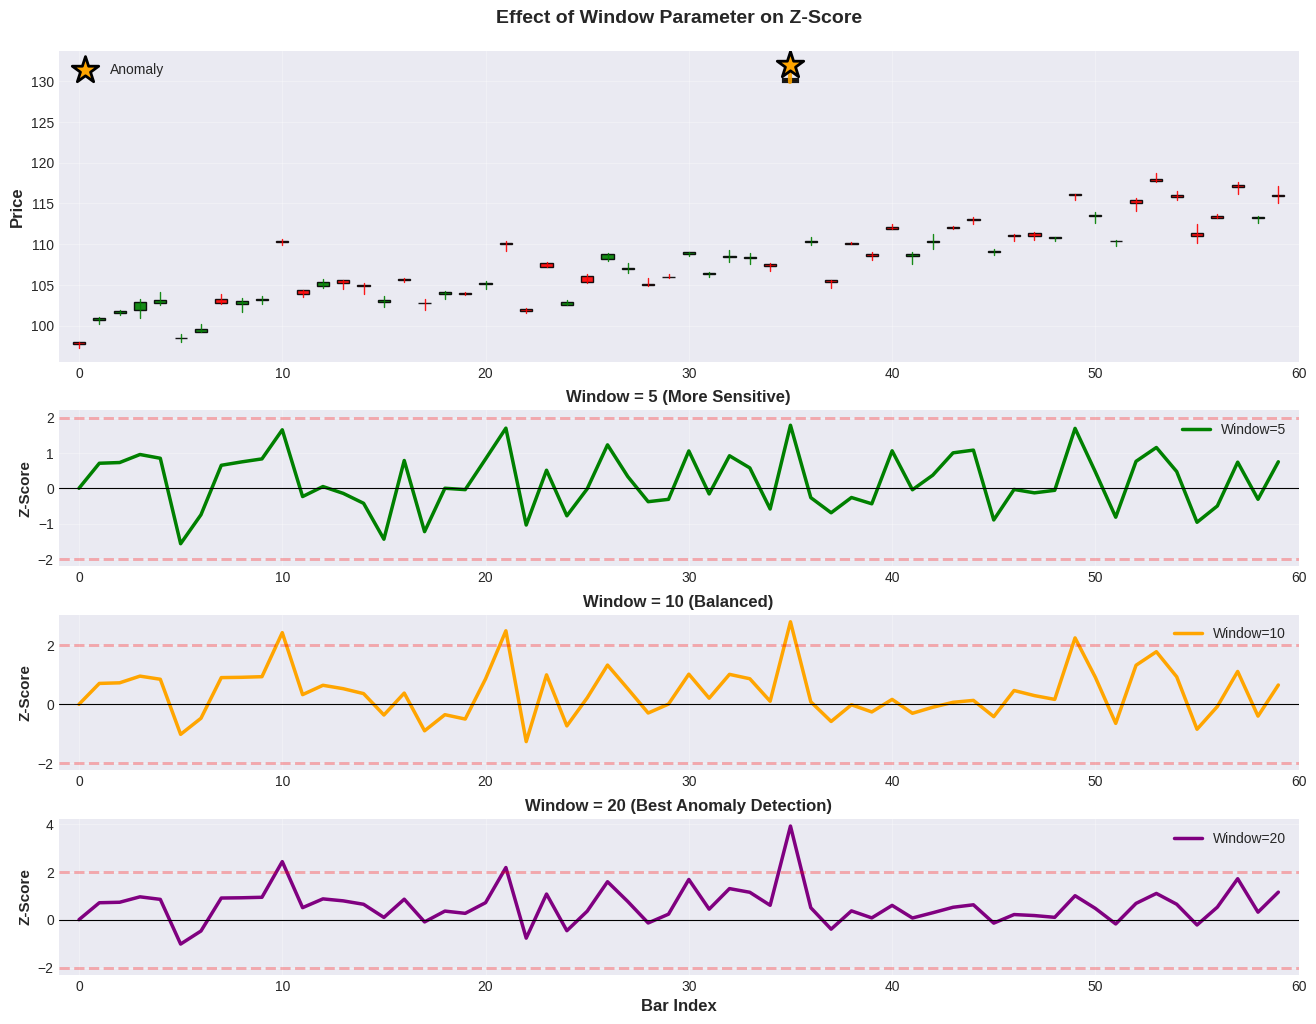

Z-Score at anomaly (bar 35):
  Window=5:  1.78
  Window=10: 2.80
  Window=20: 3.91

Larger windows provide better anomaly detection!


In [3]:
# Create trending data with volatility and anomaly
n2 = 60
dates2 = pd.date_range('2024-01-01 10:00', periods=n2, freq='5min')

trend = np.linspace(100, 115, n2)
noise = np.random.randn(n2) * 2
closes = trend + noise
closes[35] = 130  # Anomaly

# Create OHLC
opens2 = closes + np.random.randn(n2) * 0.3
highs2 = np.maximum(opens2, closes) + np.abs(np.random.randn(n2)) * 0.5
lows2 = np.minimum(opens2, closes) - np.abs(np.random.randn(n2)) * 0.5
highs2[35] = closes[35] + 2  # Make anomaly stand out

volumes2 = 1000 + np.abs(np.random.randn(n2)) * 200

df2 = pd.DataFrame({'open': opens2, 'high': highs2, 'low': lows2, 'close': closes, 'volume': volumes2}, index=dates2)

# Calculate Z-Score with different windows
result_w5 = zscore(df2, window=5)
result_w10 = zscore(df2, window=10)
result_w20 = zscore(df2, window=20)

# Plot
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(4, 1, height_ratios=[3, 1.5, 1.5, 1.5], hspace=0.25)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)
ax4 = fig.add_subplot(gs[3], sharex=ax1)

# Candlesticks
for i in range(len(df2)):
    color = 'green' if df2['close'].iloc[i] >= df2['open'].iloc[i] else 'red'
    if i == 35:
        color = 'orange'
        lw = 3
    else:
        lw = 1
    ax1.plot([i, i], [df2['low'].iloc[i], df2['high'].iloc[i]], color=color, linewidth=lw, alpha=0.9)
    height = abs(df2['close'].iloc[i] - df2['open'].iloc[i])
    if height < 0.05: height = 0.15
    bottom = min(df2['open'].iloc[i], df2['close'].iloc[i])
    ax1.add_patch(plt.Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, edgecolor='black', linewidth=lw, alpha=0.9))

ax1.scatter([35], [df2['high'].iloc[35]], s=400, marker='*', color='orange', edgecolor='black', linewidth=2, zorder=5, label='Anomaly')
ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('Effect of Window Parameter on Z-Score', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.set_xlim(-1, len(df2))

# Window = 5
zscore_w5 = result_w5['close_zscore'].values
ax2.plot(range(len(zscore_w5)), zscore_w5, 'green', linewidth=2.5, label='Window=5')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax2.axhline(2, color='red', linestyle='--', alpha=0.3, linewidth=2)
ax2.axhline(-2, color='red', linestyle='--', alpha=0.3, linewidth=2)
ax2.set_ylabel('Z-Score', fontsize=11, fontweight='bold')
ax2.set_title('Window = 5 (More Sensitive)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim(-1, len(df2))

# Window = 10
zscore_w10 = result_w10['close_zscore'].values
ax3.plot(range(len(zscore_w10)), zscore_w10, 'orange', linewidth=2.5, label='Window=10')
ax3.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax3.axhline(2, color='red', linestyle='--', alpha=0.3, linewidth=2)
ax3.axhline(-2, color='red', linestyle='--', alpha=0.3, linewidth=2)
ax3.set_ylabel('Z-Score', fontsize=11, fontweight='bold')
ax3.set_title('Window = 10 (Balanced)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.set_xlim(-1, len(df2))

# Window = 20
zscore_w20 = result_w20['close_zscore'].values
ax4.plot(range(len(zscore_w20)), zscore_w20, 'purple', linewidth=2.5, label='Window=20')
ax4.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax4.axhline(2, color='red', linestyle='--', alpha=0.3, linewidth=2)
ax4.axhline(-2, color='red', linestyle='--', alpha=0.3, linewidth=2)
ax4.set_xlabel('Bar Index', fontsize=12, fontweight='bold')
ax4.set_ylabel('Z-Score', fontsize=11, fontweight='bold')
ax4.set_title('Window = 20 (Best Anomaly Detection)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.set_xlim(-1, len(df2))

plt.tight_layout()
plt.show()

print("Z-Score at anomaly (bar 35):")
print(f"  Window=5:  {result_w5['close_zscore'].iloc[35]:.2f}")
print(f"  Window=10: {result_w10['close_zscore'].iloc[35]:.2f}")
print(f"  Window=20: {result_w20['close_zscore'].iloc[35]:.2f}")
print("\nLarger windows provide better anomaly detection!")

## Scenario 3: Volume Analysis
Use Z-Score to detect unusual volume

/tmp/user/ipykernel_2525924/824804395.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


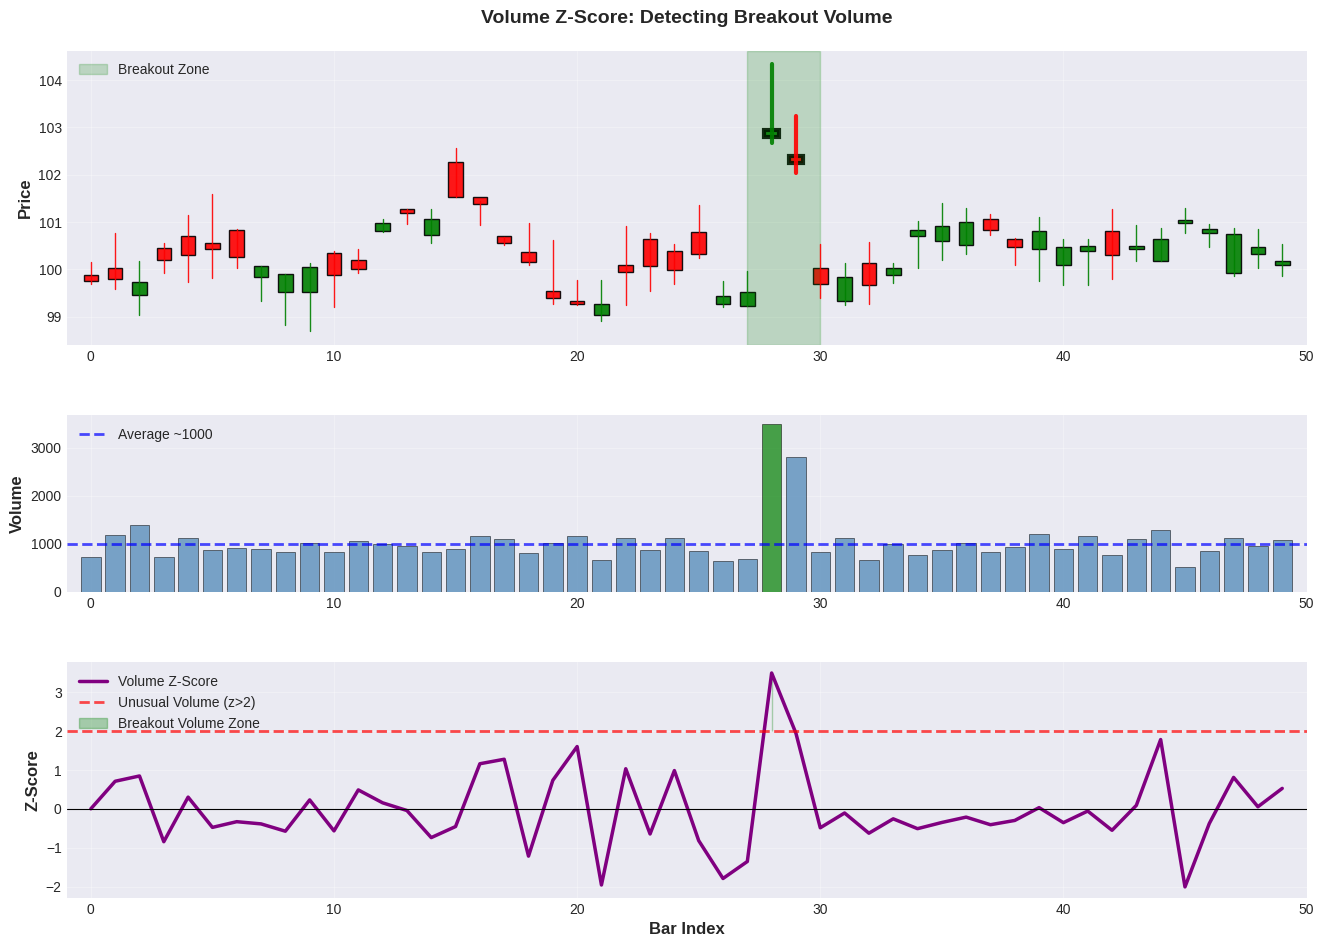

Volume spike Z-Score: 3.49
Normal volume: ~1000
Spike volume: 3500
This is 3.5x normal volume!


In [4]:
# Create OHLCV data with volume spike
n3 = 50
dates3 = pd.date_range('2024-01-01 11:00', periods=n3, freq='5min')

base_volume = 1000
volumes3 = base_volume + np.random.randn(n3) * 200
volumes3 = np.abs(volumes3)  # Ensure positive
volumes3[28] = 3500  # Volume spike (breakout)
volumes3[29] = 2800  # Follow-through

# Price moves up on volume
closes3 = 100 + np.cumsum(np.random.randn(n3) * 0.4)
closes3[28:30] += 3  # Price jumps on volume

opens3 = closes3 + np.random.randn(n3) * 0.3
highs3 = np.maximum(opens3, closes3) + np.abs(np.random.randn(n3)) * 0.4
lows3 = np.minimum(opens3, closes3) - np.abs(np.random.randn(n3)) * 0.4

# Make breakout candles larger
highs3[28] = closes3[28] + 1.5
highs3[29] = closes3[29] + 1.0

df3 = pd.DataFrame({'open': opens3, 'high': highs3, 'low': lows3, 'close': closes3, 'volume': volumes3}, index=dates3)

# Calculate Z-Score for volume
result3 = zscore(df3, column='volume', window=15)

# Plot
fig = plt.figure(figsize=(16, 11))
gs = GridSpec(3, 1, height_ratios=[2.5, 1.5, 2], hspace=0.3)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)

# Candlesticks
for i in range(len(df3)):
    color = 'green' if df3['close'].iloc[i] >= df3['open'].iloc[i] else 'red'
    if i in [28, 29]:
        lw = 3
    else:
        lw = 1
    ax1.plot([i, i], [df3['low'].iloc[i], df3['high'].iloc[i]], color=color, linewidth=lw, alpha=0.9)
    height = abs(df3['close'].iloc[i] - df3['open'].iloc[i])
    if height < 0.05: height = 0.15
    bottom = min(df3['open'].iloc[i], df3['close'].iloc[i])
    ax1.add_patch(plt.Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, edgecolor='black', linewidth=lw, alpha=0.9))

ax1.axvspan(27, 30, alpha=0.2, color='green', label='Breakout Zone')
ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('Volume Z-Score: Detecting Breakout Volume', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.set_xlim(-1, len(df3))

# Volume
vol_zscore = result3['volume_zscore'].values
colors_vol = ['green' if z > 2 else 'steelblue' for z in vol_zscore]
ax2.bar(range(len(df3)), df3['volume'], color=colors_vol, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.axhline(base_volume, color='blue', linestyle='--', label=f'Average ~{base_volume:.0f}', linewidth=2, alpha=0.7)
ax2.set_ylabel('Volume', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')
ax2.set_xlim(-1, len(df3))

# Volume Z-Score
ax3.plot(range(len(vol_zscore)), vol_zscore, 'purple', linewidth=2.5, label='Volume Z-Score')
ax3.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax3.axhline(2, color='red', linestyle='--', label='Unusual Volume (z>2)', linewidth=2, alpha=0.7)
ax3.fill_between(range(len(df3)), 2, vol_zscore,
                  where=(vol_zscore > 2), alpha=0.3, color='green', label='Breakout Volume Zone')
ax3.set_xlabel('Bar Index', fontsize=12, fontweight='bold')
ax3.set_ylabel('Z-Score', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='upper left')
ax3.set_xlim(-1, len(df3))

plt.tight_layout()
plt.show()

print(f"Volume spike Z-Score: {result3['volume_zscore'].iloc[28]:.2f}")
print(f"Normal volume: ~{base_volume:.0f}")
print(f"Spike volume: {df3['volume'].iloc[28]:.0f}")
print(f"This is {df3['volume'].iloc[28] / base_volume:.1f}x normal volume!")

## Scenario 4: Mean Reversion Strategy
Trading signals based on Z-Score extremes

/tmp/user/ipykernel_2525924/2904959738.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


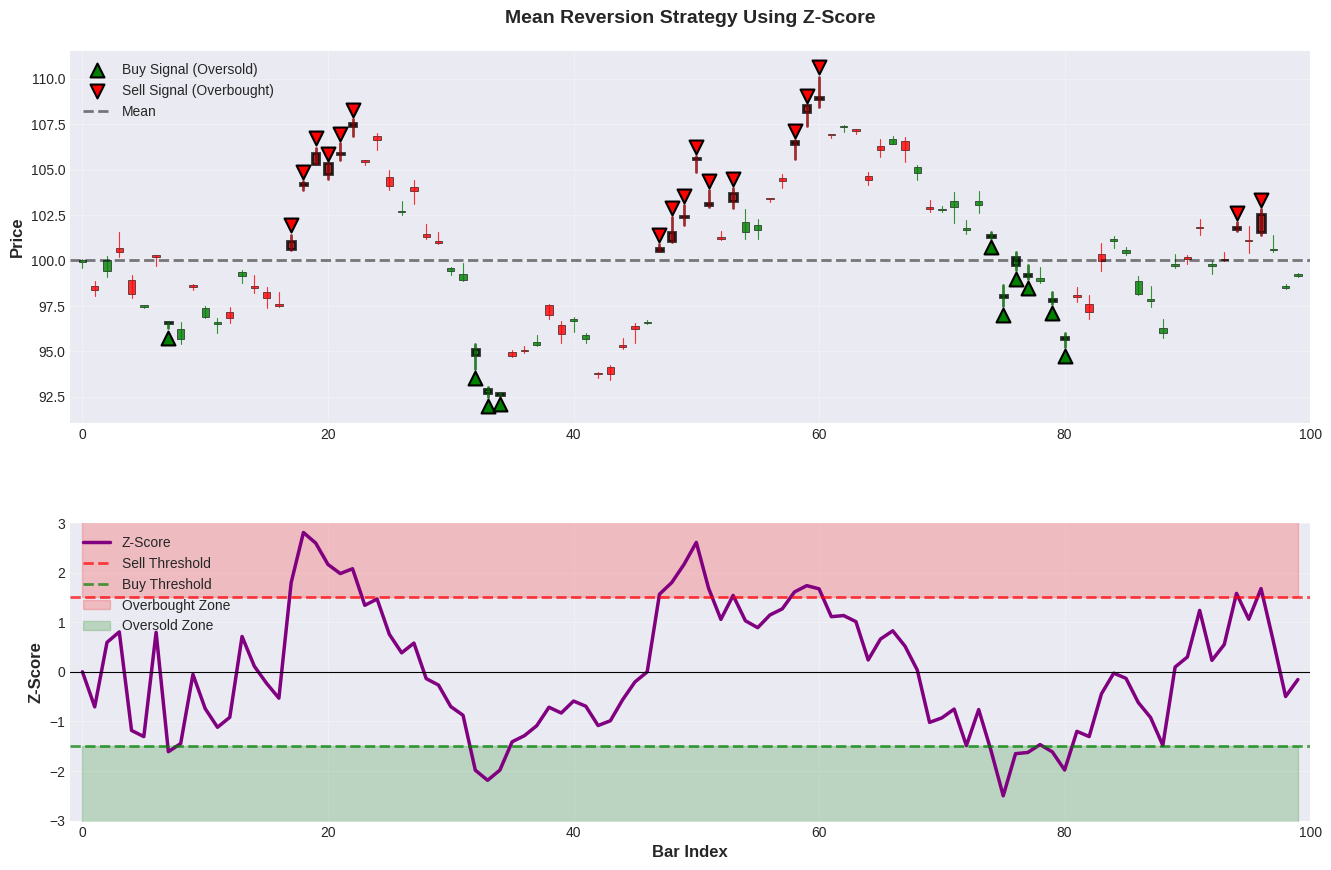

Total buy signals: 10
Total sell signals: 17

Strategy: Buy when Z-Score < -1.5, Sell when Z-Score > 1.5


In [5]:
# Create mean-reverting price data
np.random.seed(123)
n4 = 100
dates4 = pd.date_range('2024-01-01 09:30', periods=n4, freq='5min')

mean_price = 100
closes4 = np.zeros(n4)
closes4[0] = mean_price

# Create mean-reverting random walk
for i in range(1, n4):
    reversion = 0.1 * (mean_price - closes4[i-1])  # Pull toward mean
    noise = np.random.randn() * 1.5
    closes4[i] = closes4[i-1] + reversion + noise

# Create OHLC
opens4 = closes4 + np.random.randn(n4) * 0.3
highs4 = np.maximum(opens4, closes4) + np.abs(np.random.randn(n4)) * 0.4
lows4 = np.minimum(opens4, closes4) - np.abs(np.random.randn(n4)) * 0.4
volumes4 = 1000 + np.abs(np.random.randn(n4)) * 200

df4 = pd.DataFrame({'open': opens4, 'high': highs4, 'low': lows4, 'close': closes4, 'volume': volumes4}, index=dates4)

result4 = zscore(df4, window=20)

# Generate trading signals
z = result4['close_zscore']
buy_signals = (z < -1.5)  # Oversold
sell_signals = (z > 1.5)   # Overbought

# Plot
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 1, height_ratios=[2.5, 2], hspace=0.3)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Candlesticks with signals
for i in range(len(df4)):
    if buy_signals.iloc[i]:
        color = 'darkgreen'
        lw = 2
    elif sell_signals.iloc[i]:
        color = 'darkred'
        lw = 2
    else:
        color = 'green' if df4['close'].iloc[i] >= df4['open'].iloc[i] else 'red'
        lw = 0.8
    
    ax1.plot([i, i], [df4['low'].iloc[i], df4['high'].iloc[i]], color=color, linewidth=lw, alpha=0.8)
    height = abs(df4['close'].iloc[i] - df4['open'].iloc[i])
    if height < 0.05: height = 0.1
    bottom = min(df4['open'].iloc[i], df4['close'].iloc[i])
    ax1.add_patch(plt.Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, edgecolor='black', 
                                  linewidth=lw if lw > 1 else 0.5, alpha=0.8))

# Add signal markers
ax1.scatter(df4.index[buy_signals].map(lambda x: list(df4.index).index(x)), 
            df4['low'][buy_signals] - 0.5, color='green', s=100, marker='^', 
            label='Buy Signal (Oversold)', zorder=5, edgecolor='black', linewidth=1.5)
ax1.scatter(df4.index[sell_signals].map(lambda x: list(df4.index).index(x)), 
            df4['high'][sell_signals] + 0.5, color='red', s=100, marker='v', 
            label='Sell Signal (Overbought)', zorder=5, edgecolor='black', linewidth=1.5)
ax1.axhline(mean_price, color='black', linestyle='--', alpha=0.5, label='Mean', linewidth=2)
ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('Mean Reversion Strategy Using Z-Score', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1.set_xlim(-1, len(df4))

# Z-Score with thresholds
zscore_vals4 = z.values
ax2.plot(range(len(zscore_vals4)), zscore_vals4, 'purple', linewidth=2.5, label='Z-Score')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax2.axhline(1.5, color='red', linestyle='--', linewidth=2, label='Sell Threshold', alpha=0.7)
ax2.axhline(-1.5, color='green', linestyle='--', linewidth=2, label='Buy Threshold', alpha=0.7)
ax2.fill_between(range(len(df4)), 1.5, 5, alpha=0.2, color='red', label='Overbought Zone')
ax2.fill_between(range(len(df4)), -1.5, -5, alpha=0.2, color='green', label='Oversold Zone')
ax2.set_xlabel('Bar Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Z-Score', fontsize=12, fontweight='bold')
ax2.set_ylim(-3, 3)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper left')
ax2.set_xlim(-1, len(df4))

plt.tight_layout()
plt.show()

print(f"Total buy signals: {buy_signals.sum()}")
print(f"Total sell signals: {sell_signals.sum()}")
print("\nStrategy: Buy when Z-Score < -1.5, Sell when Z-Score > 1.5")

## Key Takeaways

**Z-Score Interpretation:**
- **Z = 0**: Price at rolling mean (neutral)
- **Z > 2**: More than 2 std devs above mean (overbought/unusual)
- **Z < -2**: More than 2 std devs below mean (oversold/unusual)

**Window Parameter Effects:**
- **Small window (5-10)**: More sensitive, faster signals, more noise
- **Medium window (15-20)**: Balanced sensitivity and stability
- **Large window (30+)**: Smoother, better anomaly detection, slower signals

**Use Cases:**
1. **Price anomaly detection**: Identify unusual price movements
2. **Volume spike detection**: Find breakout/distribution patterns
3. **Mean reversion trading**: Enter when price deviates significantly from mean
4. **Risk management**: Avoid trading during extreme Z-Score values

**Best Practices:**
- Combine with trend indicators (don't fade strong trends)
- Use different thresholds for different assets (volatility varies)
- Larger windows better for anomaly detection
- Works on any column: price, volume, volatility, etc.

**Trading Strategy Guidelines:**
- **Mean Reversion**: Buy Z < -1.5, Sell Z > 1.5
- **Breakout Confirmation**: High volume Z-Score (>2) validates price moves
- **Risk Filter**: Avoid entering when |Z| > 3 (extreme conditions)
- **Window Selection**: Use 20 for daily data, 10-15 for intraday

## Feature Showcase: Safety & Configuration

In [ ]:
# Configuration & Validation Showcase
# ---------------------------------------------------------
import pandas as pd
import numpy as np
from indikator.zscore import zscore

# 1. Configuration with .Config()
print(f"--- Custom zscore Configuration ---")
# Create a fully configured version of the indicator
# This factory pattern validates parameters at creation time
custom_zscore = zscore.Config(window=30).make()
print(f"Created: {custom_zscore}")

# 2. Validation Safety
print(f"
--- Input Validation Safety ---")
try:
    # Attempt to use invalid data (NaN values)
    invalid_data = pd.Series([1.0, float('nan')]) # NaN values
    print("Attempting calculation with invalid inputs...")
    zscore(invalid_data)
except Exception as e:
    # The @validated decorator automatically catches the issue
    print(f"✓ Validator caught error as expected:
  {e}")
